# <font color=blue><div align="center">Seats Allocation within an Aircraft</div></font>

### <font color=blue><div align="center">29-02-2024</div></font>

## Modules

In [1]:
# Basic modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table
import random
import json
import os

# Gurobi module
from gurobipy import *

## Data Extraction

In [2]:
# Load the Excel file into a pandas DataFrame


df_21Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=0 , skipfooter=2)
df_22Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=1 , skipfooter=2)
df_23Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=2 , skipfooter=2)
df_24Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=3 , skipfooter=2)
df_30Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=4 , skipfooter=2)
df_05Nov = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=5 , skipfooter=2)
df_07Nov = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=6 , skipfooter=2)


In [3]:
#Display the dataframe
dfs = {
    '21Oct': df_21Oct,
    '22Oct': df_22Oct,
    '23Oct': df_23Oct,
    '24Oct': df_24Oct,
    '30Oct': df_30Oct,
    '05Nov': df_05Nov,
    '07Nov': df_07Nov
}

# Ask user to choose a date
date = input('Choose the date you want to explore from the following: 21Oct, 22Oct, 23Oct, 24Oct, 30Oct, 05Nov, 07Nov: ')

# Access DataFrame based on user's input
df = dfs.get(date,"Invalid date selection." )

df

,Numéro du groupe,Femmes,Hommes,WCHR,TransitTime
0,1,NaN,1.0,NaN,01:15:00
1,2,1.0,NaN,NaN,00:00:00
2,3,NaN,1.0,NaN,00:00:00
3,4,1.0,NaN,NaN,00:00:00
4,5,NaN,2.0,NaN,05:25:00
...,...,...,...,...,...
106,107,1.0,NaN,NaN,03:30:00
107,108,2.0,NaN,NaN,05:25:00
108,109,2.0,NaN,NaN,05:25:00
109,110,2.0,NaN,NaN,01:35:00


The code in the cells below creates a dictionary Passengers defined as follows:

- Passengers Keys: IDs of passengers.
- Passengers Items: For each ID in Passengers, we specify its *type* (female: 0, male: 1, disabled: 2), its *group number*, and its *transit time*.

Notice that for passengers with a transit time equal to 0 or larger than 2 hours, the transit time in the dictionary is set to $\infty$


In [4]:
def convert_TransitTime(time_val):

    # Convert time to minutes
    total_minutes = time_val.hour * 60 + time_val.minute
    
    # Check if total minutes is greater than 2 hours or equal to 0
    if total_minutes > 120 or total_minutes == 0:
        return float('inf')  # Return infinity
    else:
        return total_minutes

df['TransitTime'] = df['TransitTime'].apply(convert_TransitTime)

In [5]:
# Create Passengers dictionary
Passengers = dict()
i = 1

number_f = 0
number_m = 0
number_d = 0

transit_times = set()

# Groups : dict[int : List[int]]

Passengers = dict()
i = 1

for group in df.itertuples():
    if not pd.isna(group[2]):
        for k in range(int(group[2])):
            Passengers[i] = {'type': 0, 'group':group[1], 'transit':group[5]}  # 0 <-> female 
            number_f += 1
            transit_times.add(group[5])
            i+=1
    if not pd.isna(group[3]):
        for k in range(int(group[3])):
            Passengers[i] = {'type': 1, 'group':group[1], 'transit':group[5]} # 1 <-> male 
            number_m += 1
            transit_times.add(group[5])
            i+=1
    if not pd.isna(group[4]):
        for k in range(int(group[4])):
            Passengers[i] = {'type': 2, 'group':group[1], 'transit':group[5]} # 2 <-> WCHR
            number_d += 1
            transit_times.add(group[5])
            i+=1
    


    
Passengers 

{1: {'type': 1, 'group': 1, 'transit': 75.0},
 2: {'type': 0, 'group': 2, 'transit': inf},
 3: {'type': 1, 'group': 3, 'transit': inf},
 4: {'type': 0, 'group': 4, 'transit': inf},
 5: {'type': 1, 'group': 5, 'transit': inf},
 6: {'type': 1, 'group': 5, 'transit': inf},
 7: {'type': 0, 'group': 6, 'transit': inf},
 8: {'type': 0, 'group': 7, 'transit': inf},
 9: {'type': 0, 'group': 8, 'transit': 80.0},
 10: {'type': 1, 'group': 8, 'transit': 80.0},
 11: {'type': 1, 'group': 9, 'transit': inf},
 12: {'type': 0, 'group': 10, 'transit': inf},
 13: {'type': 0, 'group': 11, 'transit': inf},
 14: {'type': 1, 'group': 11, 'transit': inf},
 15: {'type': 1, 'group': 12, 'transit': 70.0},
 16: {'type': 1, 'group': 13, 'transit': inf},
 17: {'type': 0, 'group': 14, 'transit': inf},
 18: {'type': 1, 'group': 14, 'transit': inf},
 19: {'type': 1, 'group': 15, 'transit': inf},
 20: {'type': 1, 'group': 16, 'transit': 95.0},
 21: {'type': 0, 'group': 17, 'transit': 60.0},
 22: {'type': 1, 'group': 1

We define a dictionnary *Groups*, containing as keys the ids of groups with more than two passengers and as values, the list of the members of the group

In [6]:
Groups = dict()


for i, passager in Passengers.items():

    if passager['group'] in Groups:
        Groups[passager['group']].append(i)
    else :
        Groups[passager['group']] = [i]

Keys = list(Groups.keys()).copy()


for i in Keys:
        if len(Groups[i]) ==1: del(Groups[i])
Groups

{5: [5, 6],
 8: [9, 10],
 11: [13, 14],
 14: [17, 18],
 17: [21, 22],
 19: [24, 25, 26, 27],
 20: [28, 29, 30, 31],
 21: [32, 33],
 23: [35, 36],
 24: [37, 38],
 27: [41, 42],
 31: [46, 47],
 34: [50, 51],
 35: [52, 53],
 39: [57, 58],
 45: [64, 65],
 51: [71, 72],
 55: [76, 77],
 56: [78, 79],
 57: [80, 81],
 59: [83, 84],
 61: [86, 87],
 63: [89, 90],
 65: [92, 93, 94],
 68: [97, 98],
 71: [101, 102],
 77: [108, 109],
 87: [119, 120],
 92: [125, 126],
 95: [129, 130],
 103: [138, 139],
 104: [140, 141],
 108: [145, 146],
 109: [147, 148],
 110: [149, 150]}

Definition of parameters necessary for the following steps

In [7]:
weight_f = 70
weight_m = 85
weight_d = 92.5

if sum([4*number_d,number_f,number_m]) <= 174 :
    number_of_rows = 29 #Airbus A320
else :
    number_of_rows = 35 #Airbus A321

number_of_columns = 7 # a(A B C AISLE D E F)


---

---

# Static Model

Defining the relevant variables of the problem

The binary variables $AssignmentVarDict[(i,j,k)]$ specify whether the seat located at position $(i,j)$ is occupied by passenger $k$.

In [8]:

m = Model("Seats_Allocation")

AssignmenVarDict = {(i, j, k) : m.addVar(vtype = GRB.BINARY, name=f'x_{i}_{j}_{k}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, number_of_columns + 1)
                    for k in range(1, len(Passengers)+1)}

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-06


### Constraints

- Every person has one seat

In [9]:
PERSONSEATCONSTDIC = { k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                                for i in range(1, number_of_rows + 1)
                                                for j in range(1, number_of_columns + 1) ])
                                                == 1)
                                                for k in range(1,len(Passengers)+1) }

- Every seat is allocated to a single person

In [10]:
ALLOCATIONCONSTDIC = { (i,j) : m.addConstr(quicksum([AssignmenVarDict[(i,j,k)]
                                                     for k in range(1, len(Passengers)+1)])
                                                     <=1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns+1) }

- Aisle seats are always free

In [11]:
AISLECONSTDIC = { i : m.addConstr(quicksum([AssignmenVarDict[(i,4,k)]
                                                     for k in range(1, len(Passengers)+1)])
                                                     == 0)
                                                     for i in range(1, number_of_rows + 1)   
}

- Barycenter constraint

In [12]:

i_m = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==1])

i_f = quicksum([weight_f * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==0])

i_d = quicksum([weight_d * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==2])

i_bary = (i_m + i_f +i_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

j_m = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==1])

j_f = quicksum([weight_f * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==0])

j_d = quicksum([weight_d * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==2])

j_bary = (j_m + j_f + j_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

In [13]:
IMAXBARYCONST = m.addConstr(i_bary <= 17)
IMINBARYCONST = m.addConstr(13 <= i_bary)
JMAXBARYCONST = m.addConstr(j_bary <= 5)
JMINBARYCONST = m.addConstr(3 <= j_bary )

- A disabeled person has 4 seats on the aisle side

In [14]:

SeatPer_WCHR_CONST = {k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)] 
                                               for i in range(1, number_of_rows ) 
                                               for j in [3, 6] 
                                               ]) == 1, name=f"SeatPerWCHR{k}")
                                               for k in range(1, len(Passengers) + 1)
                                               if Passengers[k]['type'] == 2}

for k in range(1, len(Passengers) + 1):
    if Passengers[k]['type'] == 2:
        for i in range(1, number_of_rows):
            for j in [3, 6]:
                m.addConstr(AssignmenVarDict[(i, j, k)] + quicksum(
                      [AssignmenVarDict[(i, j - 1, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i}_{j-1}')
                
                m.addConstr(AssignmenVarDict[(i, j, k)] +quicksum(
                      [AssignmenVarDict[(i+1, j, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i+1}_{j}')
                m.addConstr(AssignmenVarDict[(i, j, k)]+ quicksum(
                      [AssignmenVarDict[(i+1, j - 1, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1,  
                            name=f'Neighbor_WCHR{k}_{i+1}_{j-1}')

## Objective Transit

- Transit time

In [15]:
transit_obj = quicksum( [ AssignmenVarDict[(i,j,k)]* i*(1/Passengers[k]['transit'])
                      for i in range(1, number_of_rows+1)
                      for j in range(1, number_of_columns+1 )
                      for k in range(1, len(Passengers)+1)
                      if Passengers[k]['transit'] != float('inf') ])

m.setObjective(transit_obj, GRB.MINIMIZE)

m.params.outputflag = 0 

m.update()

- Optimisation - Objective Time

In [16]:
m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'Obj_Transit_opt = {round(m.objVal, 2)}'.center(8*14))

print()




                                             Obj_Transit_opt = 4.07                                             



In [17]:
#saving this value for later

z_old = {'objTransit': round(transit_obj.getValue(), 2) }

directory = f'./Résultats_statique/{date}/'  

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the filename
filename = f'ObjTransit_{date}.json'

pathObjTransit = directory+filename


with open(pathObjTransit, 'w') as file:
    json.dump(z_old, file)


- Transit time visualization

In [18]:
def generate_red_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_red_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[-i-1]

In [19]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passengers[k]['transit']]
                elif j > 4 :
                    data2[i-1][j-5] = k
                    if Passengers[k]['transit']!=float('inf'): colors2[i-1][j-5] = color_transit[Passengers[k]['transit']]

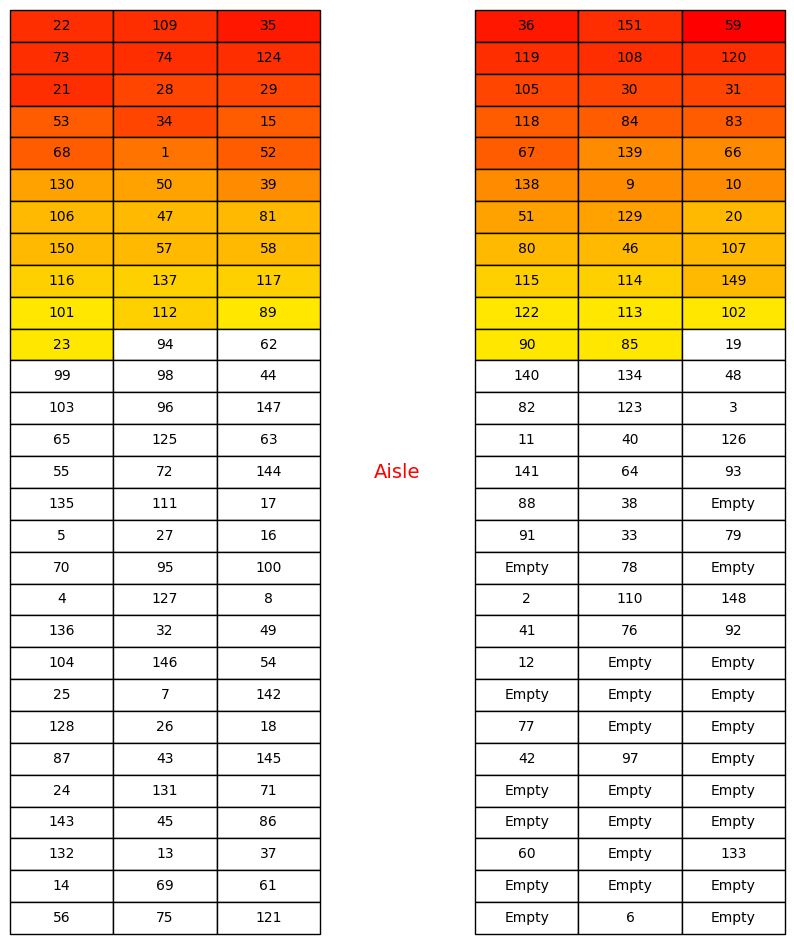

In [20]:

def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)


directory = f'./Résultats_statique/{date}/figures/'  

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the filename
filename = f'Transit_opt_{date}.png'

# Construct the full path
save_path = os.path.join(directory, filename)

# Adjust figure size
fig.set_size_inches(10, 6)  # Set the figure size to 10x6 inches (adjust as needed)

# Save the figure
fig.savefig(save_path, bbox_inches='tight')  # Use bbox_inches='tight' to ensure all elements fit


plt.show()

- Disabled visualization

In [21]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['type']==2 :
                        colors1[i-1][j-1] = '#800080'
                        colors1[i-1][j-2] = '#800080'
                        colors1[i][j-1] = '#800080'
                        colors1[i][j-2] = '#800080'
                elif j>4:
                    data2[i-1][j-5] = k
                    if Passengers[k]['type']==2:
                        colors2[i-1][j-5] = '#800080'
                        colors2[i-1][j-6] = '#800080'
                        colors2[i][j-5] = '#800080'
                        colors2[i][j-6] = '#800080'




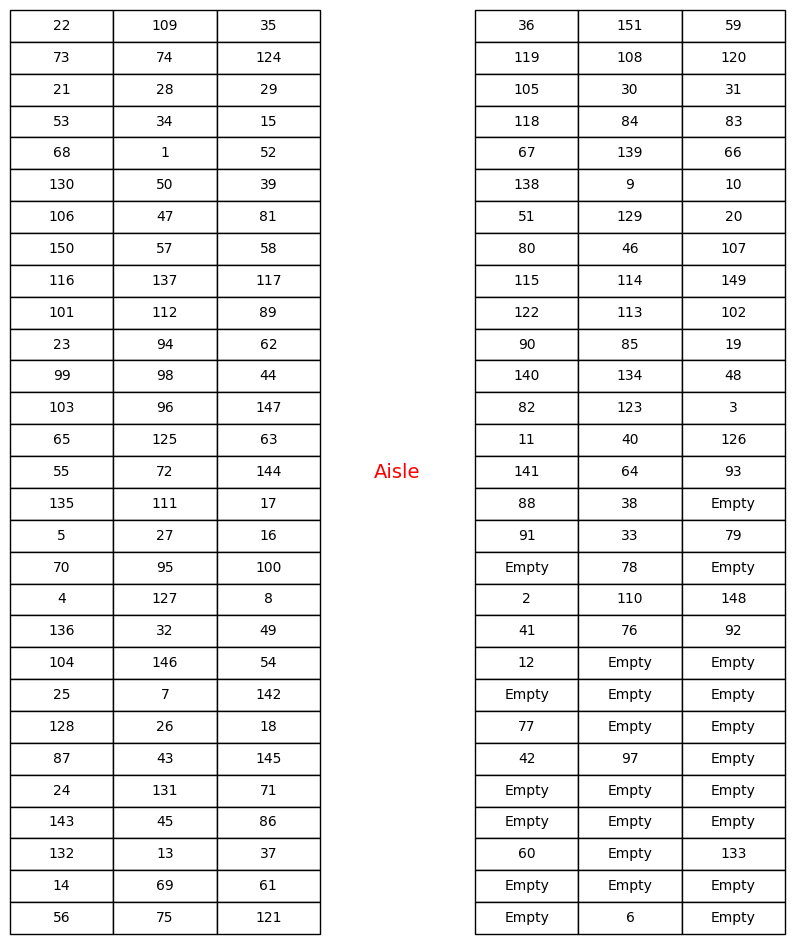

In [22]:
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

directory = f'./Résultats_statique/{date}/figures/'  

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the filename
filename = f'WCHR_{date}.png'

# Construct the full path
save_path = os.path.join(directory, filename)

# Adjust figure size
fig.set_size_inches(10, 6)  # Set the figure size to 10x6 inches (adjust as needed)

# Save the figure
fig.savefig(save_path, bbox_inches='tight')  # Use bbox_inches='tight' to ensure all elements fit

plt.show()

## Objective Grouping

> We choose to work with the objGrouping1 in the dynamic model for generating static allocations

**Fonction objective : ObjGrouping1**

The binary variables $AssignmentVarGrpDict[(g,i,j, m, n)]$ specify whether the seats located at positions $(i,j)$ and $(i,j+1)$ are occupied by passengers $m$ and $n$ from the group $g$ resp. 

In [23]:

AssignmenVarGrpDict= { (g , i, j , Groups[g][k], Groups[g][l]) : m.addVar(vtype = GRB.BINARY, name=f'Y_{i}_{j}_{Groups[g][k]}_{Groups[g][l]}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, number_of_columns)
                    for g in Groups.keys()
                    for k in range(len(Groups[g]))
                    for l in range(len(Groups[g]))

                    }

Defining some contraints to ensure the definition of the variables $AssignmentVarGrpDict[(g,i,j,m,n)]$

In [24]:

GroupingConstDict1 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,j,Groups[g][k],Groups[g][l])] <= AssignmenVarDict[(i,j,Groups[g][k])])
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(len(Groups[g]))
                                                     }

GroupingConstDict2 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,j,Groups[g][k],Groups[g][l])] <= AssignmenVarDict[(i,j+1,Groups[g][l])])
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in [1,2,5,6]
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(len(Groups[g]))
                                                     }
GroupingAisleConstDict2 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,3,Groups[g][k],Groups[g][l])] <= AssignmenVarDict[(i,5,Groups[g][l])])
                                                     for i in range(1, number_of_rows + 1)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(len(Groups[g]))
                                                     }

GroupingConstDict3 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,j,Groups[g][k],Groups[g][l])] >= 
                                       AssignmenVarDict[(i,j+1,Groups[g][l])] + AssignmenVarDict[(i,j,Groups[g][k])] -1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in [1,2,5,6]
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(len(Groups[g]))
                                                     }
GroupingAisleConstDict3 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,3,Groups[g][k],Groups[g][l])] >= 
                                       AssignmenVarDict[(i,5,Groups[g][l])] + AssignmenVarDict[(i,3,Groups[g][k])] -1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(len(Groups[g]))
                                                     }

obj_grouping = quicksum([AssignmenVarGrpDict[(g, i , j, Groups[g][k], Groups[g][l])]
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in [1,2,5,6]
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(len(Groups[g]))
                         ])

obj_grouping_aisle = quicksum([AssignmenVarGrpDict[(g, i , 3, Groups[g][k], Groups[g][l])]
                                                     for i in range(1, number_of_rows + 1)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(len(Groups[g]))
                         ])
m.setObjective(2*obj_grouping + obj_grouping_aisle, GRB.MAXIMIZE)






In [25]:

m.params.outputflag = 1

m.update()


Set parameter OutputFlag to value 1


- Optimisation - Objective Grouping


In [26]:
# Set iteration limit
m.setParam(GRB.Param.TimeLimit, 100)  # Change to the desired iterationTime limit

m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'Obj_Grouping1_opt = {round(m.objVal, 2)}'.center(8*14))

print()

Set parameter TimeLimit to value 100
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 78803 rows, 60059 columns and 369634 nonzeros
Model fingerprint: 0x1398b056
Variable types: 0 continuous, 60059 integer (60059 binary)
Coefficient statistics:
  Matrix range     [6e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]

MIP start from previous solve produced solution with objective 11 (0.04s)
Loaded MIP start from previous solve with objective 11

Presolve removed 29465 rows and 9280 columns (presolve time = 5s) ...
Presolve removed 51215 rows and 20155 columns
Presolve time: 6.09s
Presolved: 27588 rows, 39904 columns, 179699 nonzeros
Variable types: 0 continuous, 39904 integer (39904 binary)
Deterministic concurr

- Grouping Visualisation 

In [27]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(Groups))
indices_groups = list(Groups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1) }

In [28]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passengers[k]['group']]
                else:
                    data2[i-1][j-5] = k
                    if Passengers[k]['group'] in color_group: colors2[i-1][j-5] = color_group[Passengers[k]['group']]

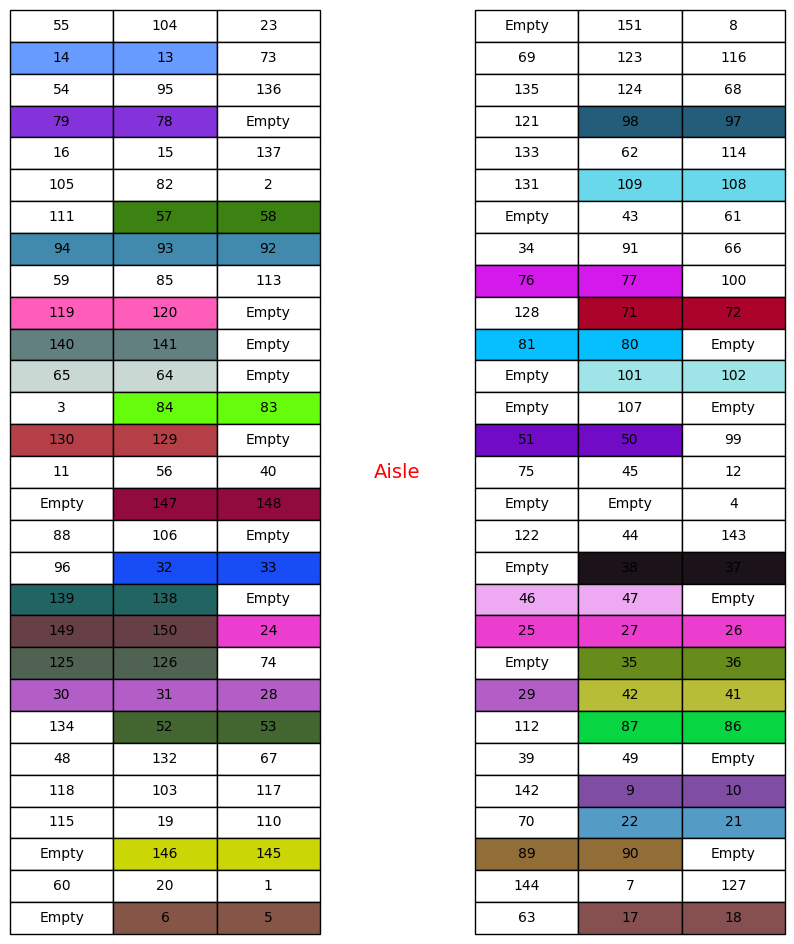

In [29]:
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

directory = f'./Résultats_statique/{date}/figures/'  

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the filename
filename = f'Grouping_opt_{date}.png'

# Construct the full path
save_path = os.path.join(directory, filename)

# Adjust figure size
fig.set_size_inches(10, 6)  # Set the figure size to 10x6 inches (adjust as needed)

# Save the figure
fig.savefig(save_path, bbox_inches='tight')  # Use bbox_inches='tight' to ensure all elements fit



plt.show()

## Coupling both objectives

In [30]:
m.setObjective(-0.7*obj_grouping + 0.3*transit_obj, GRB.MINIMIZE)

m.params.outputflag = 1

m.update()

## Optimisation

In [31]:
# Set iteration limit
m.setParam(GRB.Param.TimeLimit, 100)  # Change to the desired iterationTime limit

m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'obj_total_opt = {round(m.objVal, 2)}'.center(8*14))

print()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 78803 rows, 60059 columns and 369634 nonzeros
Model fingerprint: 0xab7fa793
Variable types: 0 continuous, 60059 integer (60059 binary)
Coefficient statistics:
  Matrix range     [6e-03, 1e+00]
  Objective range  [3e-03, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]

Loaded MIP start from previous solve with objective -22.8745

Presolve removed 56667 rows and 22881 columns
Presolve time: 4.02s
Presolved: 22136 rows, 37178 columns, 168795 nonzeros
Variable types: 0 continuous, 37178 integer (37178 binary)
Found heuristic solution: objective -23.4551470
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved with primal simplex



- Transit time visualisation

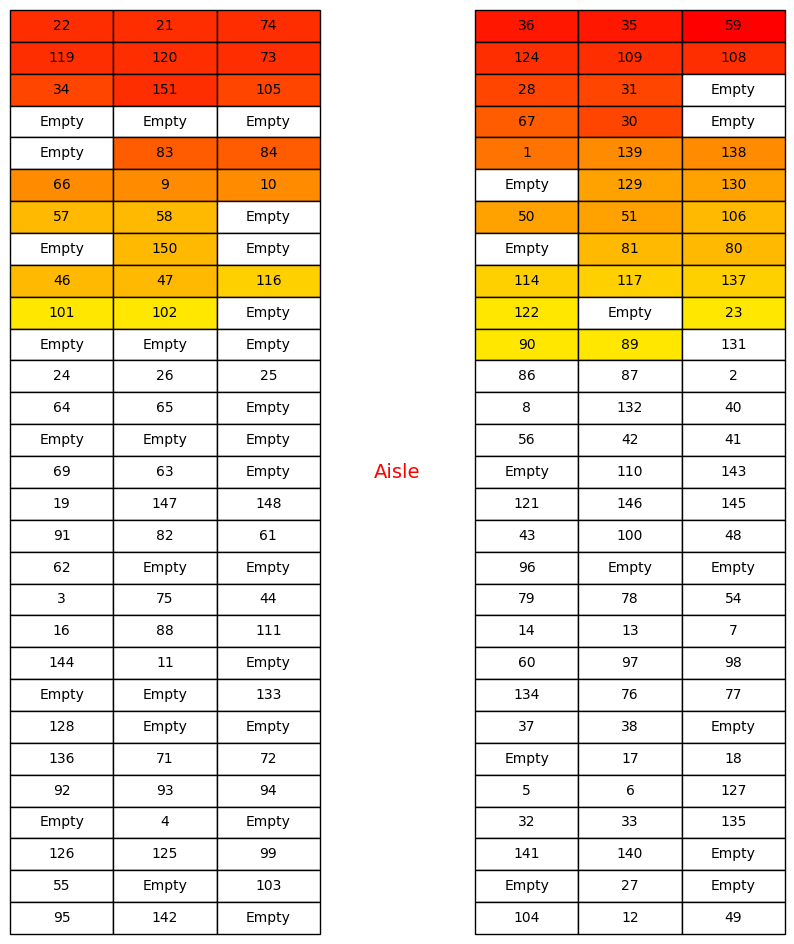

In [32]:
def generate_red_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_red_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[-i-1]

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passengers[k]['transit']]
                elif j > 4 :
                    data2[i-1][j-5] = k
                    if Passengers[k]['transit']!=float('inf'): colors2[i-1][j-5] = color_transit[Passengers[k]['transit']]


def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

directory = f'./Résultats_statique/{date}/figures/'  

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the filename
filename = f'Transit_Global_{date}.png'

# Construct the full path
save_path = os.path.join(directory, filename)

# Adjust figure size
fig.set_size_inches(10, 6)  # Set the figure size to 10x6 inches (adjust as needed)

# Save the figure
fig.savefig(save_path, bbox_inches='tight')  # Use bbox_inches='tight' to ensure all elements fit

plt.show()

- Disabled visualization

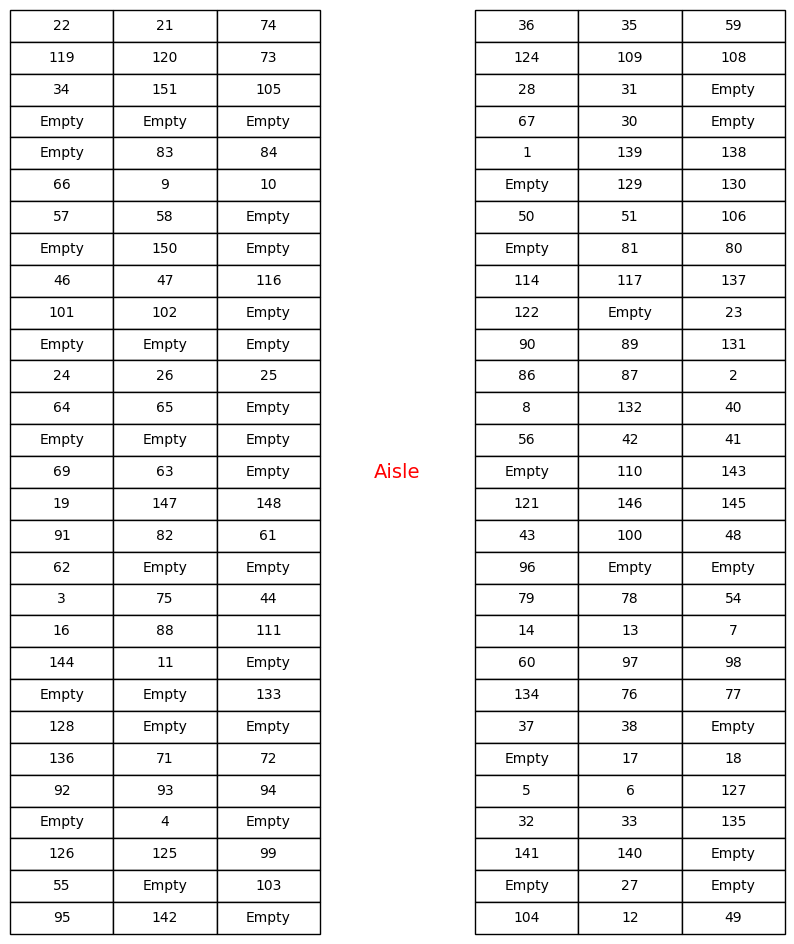

In [33]:

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['type']==2 :
                        colors1[i-1][j-1] = '#800080'
                        colors1[i-1][j-2] = '#800080'
                        colors1[i][j-1] = '#800080'
                        colors1[i][j-2] = '#800080'
                elif j>4:
                    data2[i-1][j-5] = k
                    if Passengers[k]['type']==2:
                        colors2[i-1][j-5] = '#800080'
                        colors2[i-1][j-6] = '#800080'
                        colors2[i][j-5] = '#800080'
                        colors2[i][j-6] = '#800080'

def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

directory = f'./Résultats_statique/{date}/figures/'  

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the filename
filename = f'WCHR_Global_{date}.png'

# Construct the full path
save_path = os.path.join(directory, filename)

# Adjust figure size
fig.set_size_inches(10, 6)  # Set the figure size to 10x6 inches (adjust as needed)

# Save the figure
fig.savefig(save_path, bbox_inches='tight')  # Use bbox_inches='tight' to ensure all elements fit


plt.show()

- Groups vizualisation

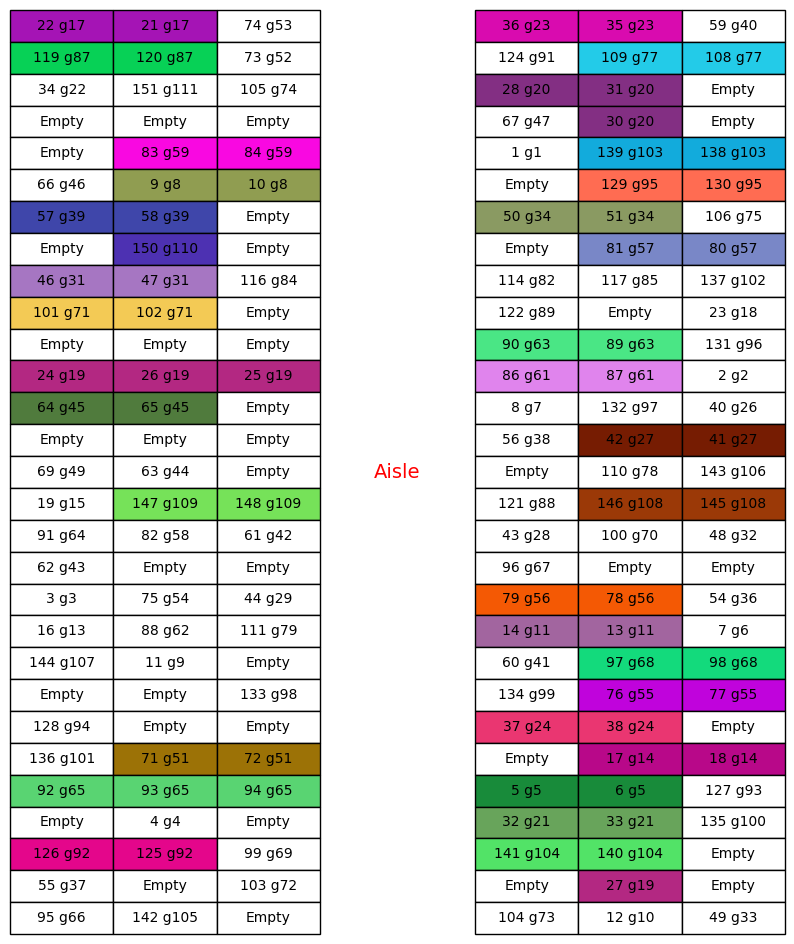

In [34]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(Groups))
indices_groups = list(Groups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1) }


data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = f"{k} g{Passengers[k]['group']}"
                    if Passengers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passengers[k]['group']]
                else:
                    data2[i-1][j-5] = f"{k} g{Passengers[k]['group']}"
                    if Passengers[k]['group'] in color_group: colors2[i-1][j-5] = color_group[Passengers[k]['group']]

                    
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

directory = f'./Résultats_statique/{date}/figures/'  

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the filename
filename = f'Grouping_Global_{date}.png'

# Construct the full path
save_path = os.path.join(directory, filename)

# Adjust figure size
fig.set_size_inches(10, 6)  # Set the figure size to 10x6 inches (adjust as needed)

# Save the figure
fig.savefig(save_path, bbox_inches='tight')  # Use bbox_inches='tight' to ensure all elements fit

plt.show()

## Metrics

**Optimal Allocation**

In [35]:
#Seats assignement :

SeatsAssignOptimDict = { (i,j) : None for i in range(1, number_of_rows + 1) for j in range(1, number_of_columns +1)}

#Passengers Assignement :

PassengersAssignOptimDict ={ k : None for k in range(1, len(Passengers) + 1)}

In [36]:
for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) +1 ):
            if round(m.getVarByName(f'x_{i}_{j}_{k}').X,1) == 1:
                SeatsAssignOptimDict[(i, j)] = k
                PassengersAssignOptimDict[k] = [i,j]

In [37]:
converted_SeatsAssignOptimDict = {str(key): value for key, value in SeatsAssignOptimDict.items()}

In [38]:
#saving optimal configuration

fileNameSeats = f"SeatsDict_{date}.json"
fileNamePassengers = f"PassengersDict_{date}.json"

directory = f'./Résultats_statique/{date}/'  

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)



pathSeats = directory+fileNameSeats
pathPassengers = directory+fileNamePassengers

with open(pathSeats, 'w') as file:
    json.dump(converted_SeatsAssignOptimDict, file)

with open(pathPassengers, 'w') as file:
    json.dump(PassengersAssignOptimDict, file)

**Calculating scores/metrics**

In [39]:
def ScoreTransit(Passengers_Assign_Dict) :
    
    z_transit = sum([Passengers_Assign_Dict[k][0]/Passengers[k]['transit'] for k in range(1, len(Passengers)+1)])

    return (1- (z_transit- z_old['objTransit'])/z_old['objTransit']) * 100

In [40]:
ScoreTransit(PassengersAssignOptimDict)

99.95048416101051

In [41]:
def score_Passenger_Transit(Passengers_Assign_Dict,Seats_Assign_Dict):

    #satisfaction de chaque passager ayant un transit vis-à-vis sa position

    Score_Passenger_ind_Transit={}
    Score_Passenger_ind_norm_Transit = {}

    for passenger , info_passenger in Passengers.items():

        if info_passenger['transit'] != float('inf'):

            i_p = Passengers_Assign_Dict[passenger][0]

            sum_front = sum([1 for i in range(1, i_p) for j in range(1, number_of_columns+1)
                          if  Passengers.get(Seats_Assign_Dict[(i, j)], {}).get('transit', float('inf')) < info_passenger['transit'] ])
            
            sum_back = sum([1 for i in range(i_p+1, number_of_rows+1) for j in range(1, number_of_columns+1)
                          if Passengers.get(Seats_Assign_Dict[(i, j)], {}).get('transit', 0 ) > info_passenger['transit']  and 
                            Passengers.get(Seats_Assign_Dict[(i, j)], {}).get('transit', 0) != float('inf')])
            
            score_pass= (sum_front+sum_back)/sum([1 for k in Passengers if Passengers[k]['transit'] != float('inf')])
            Score_Passenger_ind_Transit[passenger] = score_pass*100
            Score_Passenger_ind_norm_Transit[passenger]=Score_Passenger_ind_Transit[passenger]/max(Score_Passenger_ind_Transit.values()) *100
    return Score_Passenger_ind_Transit , Score_Passenger_ind_norm_Transit

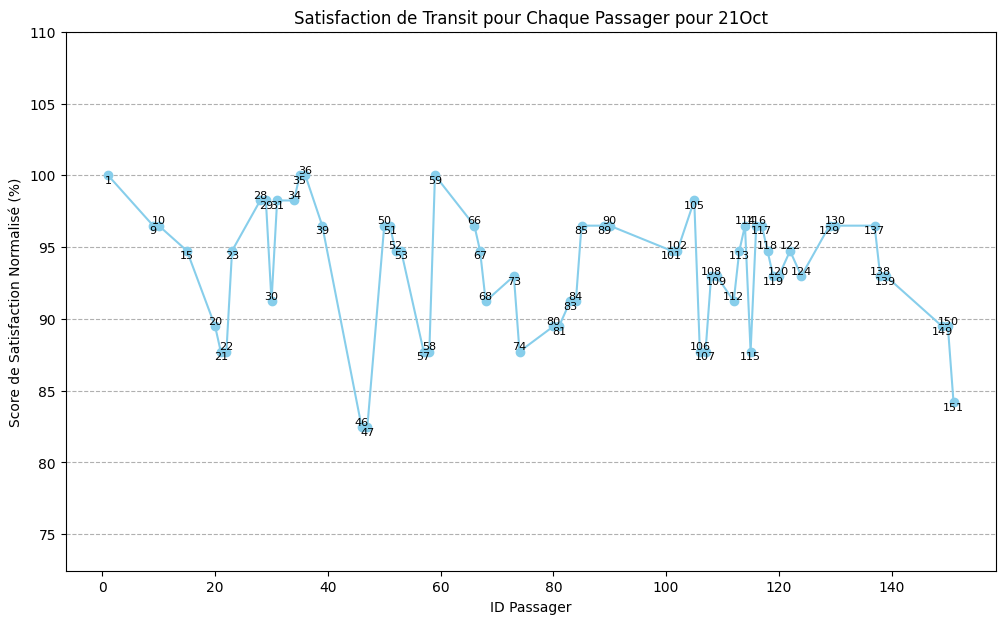

In [42]:
Score_Passenger_ind_Transit, Score_Passenger_ind_norm_Transit = score_Passenger_Transit(PassengersAssignOptimDict, SeatsAssignOptimDict)

passenger_ids = list(Score_Passenger_ind_norm_Transit.keys())
scores = list(Score_Passenger_ind_norm_Transit.values())


plt.figure(figsize=(12, 7))


plt.plot(passenger_ids, scores, marker='o', linestyle='-', color='skyblue')


for (i, score) in zip(passenger_ids, scores):
    if i%2 == 0:
        plt.text(i, score, f'{i}', ha = 'center', va='bottom', fontsize=8)  
for (i, score) in zip(passenger_ids, scores):
    if i%2 == 1:
        plt.text(i, score, f'{i}', ha = 'center', va='top', fontsize=8)

plt.title(f'Satisfaction de Transit pour Chaque Passager pour {date}')
plt.xlabel('ID Passager')
plt.ylabel('Score de Satisfaction Normalisé (%)')
plt.ylim(min(scores)-10, max(scores) + 10)

plt.grid(axis='y', linestyle='--')

directory = f'./Résultats_statique/{date}/figures/'  

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the filename
filename = f'Satisfaction_Transit_{date}.png'

# Construct the full path
save_path = os.path.join(directory, filename)


# Save the figure
plt.savefig(save_path)

plt.show()

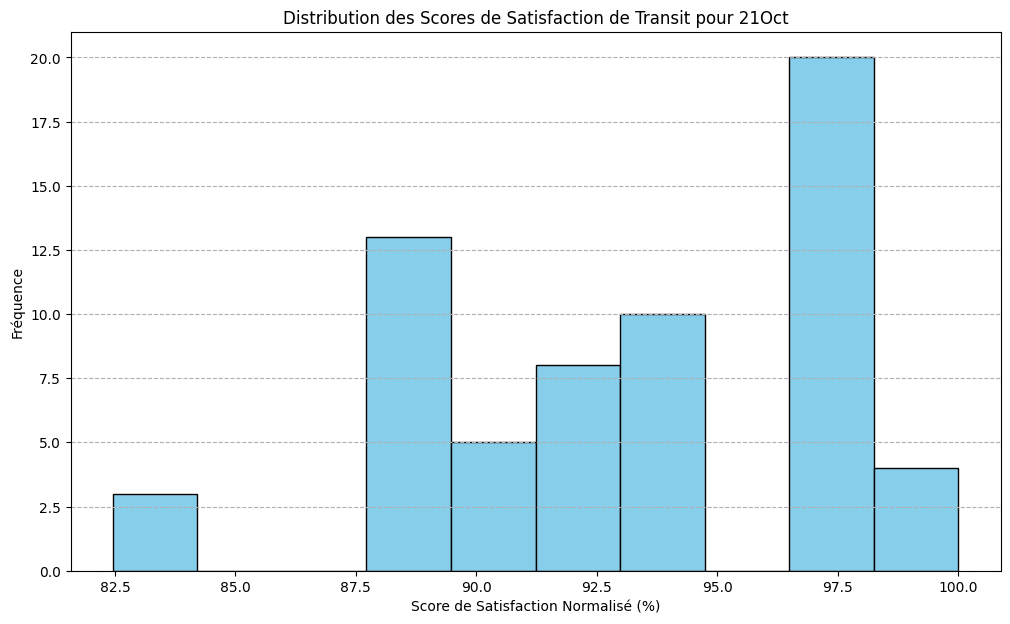

In [43]:
Score_Passenger_ind_Transit, Score_Passenger_ind_norm_Transit = score_Passenger_Transit(PassengersAssignOptimDict, SeatsAssignOptimDict)

passenger_ids = list(Score_Passenger_ind_norm_Transit.keys())
scores = list(Score_Passenger_ind_norm_Transit.values())

plt.figure(figsize=(12, 7))

# Plot histogram
plt.hist(scores, bins=10, color='skyblue', edgecolor='black')

plt.title(f'Distribution des Scores de Satisfaction de Transit pour {date}')
plt.xlabel('Score de Satisfaction Normalisé (%)')
plt.ylabel('Fréquence')

plt.grid(axis='y', linestyle='--')

directory = f'./Résultats_statique/{date}/figures/'  

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the filename
filename = f'Satisfaction_Transit_hist{date}.png'

# Construct the full path
save_path = os.path.join(directory, filename)


# Save the figure
plt.savefig(save_path)

plt.show()


In [44]:
def ScoreGrouping(Passengers_Assign_Dict, Seats_Assign_Dict) :

    satisfaction_scores = {} #satisfaction de chaque personne dans un groupe de plus de 2 personnes
    satisfaction_groups_scores ={} #satisfaction de chaque groupe de plus de 2 personnes

    for group, passengers in Groups.items():
            
            satisfaction_group = 0
            
            for k in passengers :
                i, j = Passengers_Assign_Dict[k]
                satisfaction_k = 0
                if j not in (3,5) :

                    neighbors_k = set([Seats_Assign_Dict.get((i,j-1),0), Seats_Assign_Dict.get((i,j+1),0)])

                    if not neighbors_k.intersection(set(passengers)) :
                        satisfaction_k = 0
                    else :  
                        satisfaction_k = 1
                    
                elif j == 3 : 
                    neighbors_k = set([Seats_Assign_Dict.get((i,j-1),0), Seats_Assign_Dict.get((i,j+2),0)])

                    if not neighbors_k.intersection(set(passengers)) :
                        satisfaction_k = 0
                    elif Seats_Assign_Dict.get((i,j-1),0) in passengers :
                        satisfaction_k = 1
                    else :
                        satisfaction_k = 0.5

                elif j == 5 : 
                    neighbors_k = set([Seats_Assign_Dict.get((i,j+1),0), Seats_Assign_Dict.get((i,j-2),0)])

                    if not neighbors_k.intersection(set(passengers)) :
                        satisfaction_k = 0
                    elif Seats_Assign_Dict.get((i,j+1),0) in passengers :
                        satisfaction_k = 1
                    else :
                        satisfaction_k = 0.5
                
                satisfaction_group += satisfaction_k

                satisfaction_scores[k] = satisfaction_k*100

            satisfaction_groups_scores[group] = satisfaction_group/len(passengers)*100
            


    # Calcul du score de groupement moyen (pourcentage de satisfaction)
    grouping_score = (sum(satisfaction_scores.values()) / len(satisfaction_scores))*100
    
    return grouping_score , satisfaction_scores, satisfaction_groups_scores

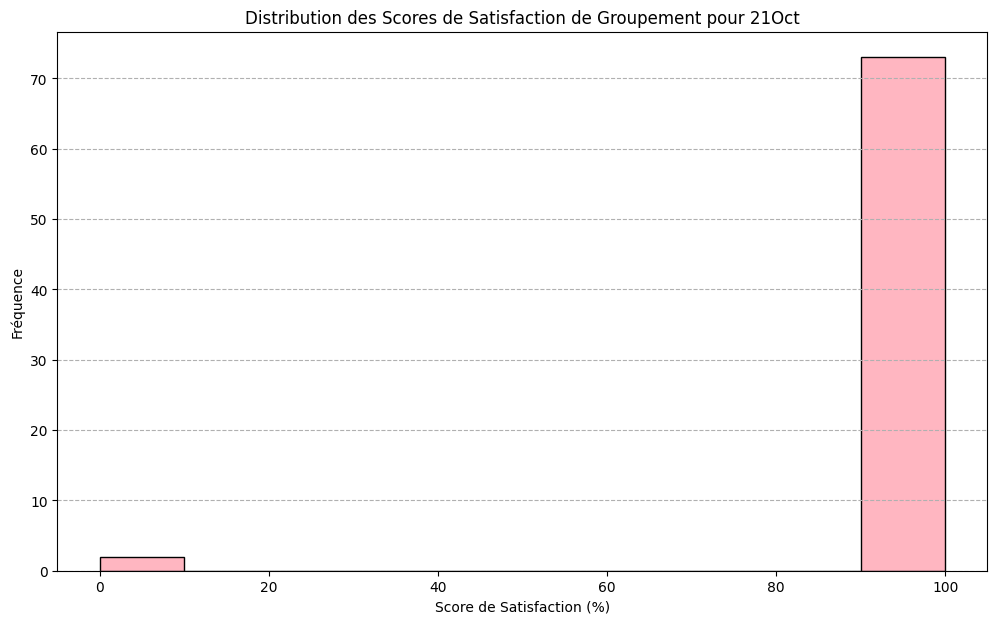

In [45]:
_ , SatisfactionScores, _ = ScoreGrouping(PassengersAssignOptimDict, SeatsAssignOptimDict)

passenger_ids = list(SatisfactionScores.keys())
scores = list(SatisfactionScores.values())

plt.figure(figsize=(12, 7))

# Plot histogram
plt.hist(scores, bins=10, color='#FFB6C1', edgecolor='black')

plt.title(f'Distribution des Scores de Satisfaction de Groupement pour {date}')
plt.xlabel('Score de Satisfaction (%)')
plt.ylabel('Fréquence')

plt.grid(axis='y', linestyle='--')

directory = f'./Résultats_statique/{date}/figures/'  

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the filename
filename = f'Satisfaction_Grouping_hist_{date}.png'

# Construct the full path
save_path = os.path.join(directory, filename)


# Save the figure
plt.savefig(save_path)

plt.show()


## Dynamic Model

**Passengers Weights**

In [46]:
WeightsPassengers = {}

for k in range(1, len(Passengers) + 1) :
    if Passengers[k]['type'] == 0 :
        WeightsPassengers[k] = weight_f
    if Passengers[k]['type'] == 1 :
        WeightsPassengers[k] = weight_m
    if Passengers[k]['type'] == 2 :
        WeightsPassengers[k] = weight_d

**All Groups**

In [47]:
AllGroups = {}

for i, passager in Passengers.items():
    group_id = passager['group']
    type_i = passager['type']

    # Check if the group already exists in AllGroups
    if group_id in AllGroups:
        group_info = AllGroups[group_id]
    else:
        # If the group doesn't exist, initialize its information
        group_info = {
            'passengers': [],
            'Nbr_female': 0,
            'Nbr_male': 0,
            'Nbr_WCHR': 0
        }
        AllGroups[group_id] = group_info

    # Update passengers list
    group_info['passengers'].append(i)

    # Update passenger type count
    if type_i == 0:
        group_info['Nbr_female'] += 1
    elif type_i == 1:
        group_info['Nbr_male'] += 1
    else:
        group_info['Nbr_WCHR'] += 1



In [48]:
fileNameAllGroups = f"AllGroups_{date}.json"

directory = f'./Résultats_statique/{date}/'  

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)



pathAllGroups = directory+fileNameAllGroups
pathPassengers = directory+fileNamePassengers

with open(pathAllGroups, 'w') as file:
    json.dump(AllGroups, file)

**Functions to select subgroups**

In [49]:
import random


def shuffle_groups(group_list, proportion):

    '''
    This function randomly selects all the groups of passengers who will choose their seats at the moment of registration.
    '''
    group_numbers = list(group_list.keys())
    # Mélanger la liste de groupes de manière aléatoire
    random.seed(3)
    random.shuffle(group_numbers)
    
    # Calculer le nombre de groupes à sélectionner
    num_selected = int(len(group_numbers) * proportion)
    
    # Sélectionner les groupes en fonction de la proportion spécifiée
    selected_groups = group_numbers[:num_selected ]
    
    return selected_groups



In [50]:
from itertools import combinations

def subgroups(grp_size, valid_seats): 

    '''
    This function returns all the sublists of n=grp_size elements from a list valid_seats.
    '''

    if grp_size > len(valid_seats) :
        return []
    elif grp_size < 1:
        return "La taille du groupe doit être d'au moins 1."
    else : 
        return [valid_seats[i: i+grp_size] for i in range(len(valid_seats) - grp_size + 1)]
    

In [51]:
subgroups(2, [(1,2),(2,4),(5,6)])

[[(1, 2), (2, 4)], [(2, 4), (5, 6)]]

In [52]:
def potential_permutations(grp_size,chosen_seats):

    '''
    This function returns all the potentiel permuations of a group of size n=grp_size
    '''

    valid_seats =[(i,j) for i in range(1,number_of_rows+1) for j in range(1,number_of_columns+1) if (j != 4 and (i,j) not in chosen_seats) ]
    
    choices = subgroups(grp_size,valid_seats)
    
    return choices

In [53]:
def permutation(Old_allocation, New_allocation, Passengers_Assign_old_Dict, Seats_Assign_old_Dict):
    '''
    This function returns the new configuration of the plane after doing the permutation between two groups of passengers
    '''

    Passengers_Assign_New_Dict, Seats_Assign_New_Dict = Passengers_Assign_old_Dict.copy(), Seats_Assign_old_Dict.copy()

    for l in range(len(Old_allocation)):

        Passenger_Assign_Old = Old_allocation[l][2]
        Passenger_Assign_New = New_allocation[l][2]


        Seat_Assign_Old = (Old_allocation[l][0],Old_allocation[l][1])
        Seat_Assign_New = (New_allocation[l][0],New_allocation[l][1])

        # Swap passenger-seat assignments in the dictionaries
        Seats_Assign_New_Dict[Seat_Assign_New] = Passenger_Assign_Old
        Seats_Assign_New_Dict[Seat_Assign_Old] = Passenger_Assign_New

        Passengers_Assign_New_Dict[Passenger_Assign_Old] = Seat_Assign_New
        if Passenger_Assign_New != None :
            Seats_Assign_New_Dict[Passenger_Assign_New] = Seat_Assign_Old

    return Passengers_Assign_New_Dict, Seats_Assign_New_Dict


In [54]:
def CheckBaryConst(Passengers_Assign_Dict):

    '''
    This function checks if the barycentre constraints are verified
    '''

    res = True 
    
    i_bary = sum([WeightsPassengers[k]*Passengers_Assign_Dict[k][0] for k in range(1, len(Passengers) + 1)])/sum(WeightsPassengers.values())
    j_bary = sum([WeightsPassengers[k]*Passengers_Assign_Dict[k][1] for k in range(1, len(Passengers) + 1)])/sum(WeightsPassengers.values())

    if i_bary > 16.5 or i_bary < 13.5 or j_bary > 4.5 or 3.5 > j_bary :
        res = False 

    return res

In [55]:
def CheckWCHConst(Passengers_Assign_Dict , Seats_Assign_Dict):

    
    '''
    This function checks if the WCHR constraints are verified
    '''

    res = True 
    for k in range(1, len(Passengers) + 1) :
        if Passengers[k]['type'] == 2 :
            i,j = Passengers_Assign_Dict[k]
            if j not in [3,6] or Seats_Assign_Dict.get((i,j-1),0) != None or Seats_Assign_Dict.get((i+1,j-1),0) != None  or Seats_Assign_Dict.get((i+1,j),0) != None :
                res = False 
                break

    return res

In [56]:

def CheckNewAllocation(Passengers_Assign_Dict,Seats_Assign_Dict):

    '''
    This function checks if the new configuration is valid or not
    '''

    res = True 

    if not CheckBaryConst(Passengers_Assign_Dict):
        res = False
        return res

    if not CheckWCHConst(Passengers_Assign_Dict, Seats_Assign_Dict):
        res = False 
        return res

    if ScoreTransit(Passengers_Assign_Dict)/ScoreTransit(PassengersAssignOptimDict) < 0.75:
        res = False
        return res
    
    if ScoreGrouping(Passengers_Assign_Dict, Seats_Assign_Dict)[0]/ScoreGrouping(PassengersAssignOptimDict, SeatsAssignOptimDict)[0] < 0.95 :
        res = False


    return res


In [57]:
def possible_permutations(group_number, chosen_seats, Passengers_Assign_old_Dict , Seats_Assign_old_Dict):

    '''
    This function returns all the valid permutations among all the possible ones
    '''

    grp_size = len(AllGroups[group_number]['passengers'])
    optimal_allocation_group = [(PassengersAssignOptimDict[k][0], PassengersAssignOptimDict[k][1],k) for k in AllGroups[group_number]['passengers']]
    res = [[(PassengersAssignOptimDict[k][0], PassengersAssignOptimDict[k][1]) for k in AllGroups[group_number]['passengers']]]

    for allocation in potential_permutations(grp_size , chosen_seats) :
        allocation_group = [(seat[0],seat[1],SeatsAssignOptimDict[(seat[0],seat[1])]) for seat in allocation]
        PassengersAssignNewDict , SeatsAssignNewDict = permutation(optimal_allocation_group,allocation_group, Passengers_Assign_old_Dict , Seats_Assign_old_Dict)
        if CheckNewAllocation(PassengersAssignNewDict,SeatsAssignNewDict) : 
            res.append(allocation)

    return res

In [58]:
def scoreAllocation(allocations_list):
    max_row_total = 0
    max_column_total = 0

    for allocation in allocations_list:
        max_row_allocation = sum(1 for seat in allocation if seat[0] <= number_of_rows / 3) / len(allocation)

        y = sum(1 for seat in allocation if seat[1] in [2, 6])
        max_column_allocation = (len(allocation) - y) / len(allocation)

        max_row_total = max(max_row_total, max_row_allocation)
        max_column_total = max(max_column_total, max_column_allocation)

    return 100 * (max_column_total + max_row_total) / 2


In [59]:
def Group_Registration(group_nbr,ChosenSeats = set(), RegisteredGroups =set(),Passengers_Assign_Dict = PassengersAssignOptimDict.copy() , Seats_Assign_Dict = SeatsAssignOptimDict.copy() ,max_choices = float('inf'), max_try=5):

    '''
    This function registers a given group
    '''

    if group_nbr in RegisteredGroups :
        print('Your group already registred ')
        return [] , ChosenSeats, RegisteredGroups ,  Passengers_Assign_Dict , Seats_Assign_Dict, None, None
        
    elif group_nbr == 0 or type(group_nbr) != int:
        print('Group number must be a positive integer')
        return [] , ChosenSeats, RegisteredGroups ,  Passengers_Assign_Dict , Seats_Assign_Dict, None, None
    else :

        choices = possible_permutations(group_nbr, ChosenSeats,Passengers_Assign_Dict, Seats_Assign_Dict)

        RandomNumbers ={}
        All_possible_allocations = {}
        Scores ={}
        for i in range(max_try) :
            random.seed(i)
            RandomNumbers[i] = sorted([0]+ random.sample(range(1, len(choices)), min(len(choices),max_choices)-1))
            All_possible_allocations[i] = [choices[n] for n in RandomNumbers[i]]
            Scores[i] = scoreAllocation(All_possible_allocations[i])

        random_numbers = RandomNumbers[max(Scores, key=Scores.get)]

        score_register = min(len(choices),max_choices)
        score_choice = max(Scores.values())

        All_options= [choices[n] for n in random_numbers]

        for n in  range(1, len(random_numbers)+1):
                print(f'Choice number {n} for group {group_nbr} : ', choices[random_numbers[n-1]])
        
        while True : 
            
            chosenAllocation_nbr = random.randint(1,len(All_options))
            break
            '''
            chosenAllocation_nbr = int(input('What\'s your chosen allocation ?'))
            if chosenAllocation_nbr not in range(1, len(All_options)):
                print(f'Choose a number between 1 and {min(len(choices),max_choices)}')
                chosenAllocation_nbr = int(input('What\'s your chosen allocation ?'))
            else : 
                break
            '''
            
            
            
        
        RegisteredGroups.add(group_nbr)
            
            
        chosenAllocation = All_options[chosenAllocation_nbr -1]
        ChosenSeats.update(seat for seat in chosenAllocation)
            
        optimal_allocation_group = [(seat[0], seat[1],Seats_Assign_Dict[seat]) for seat in choices[0] ]
        chosen_allocation_group = [(seat[0], seat[1],Seats_Assign_Dict[seat]) for seat in choices[chosenAllocation_nbr -1] ]
        PassengersAssignDict , SeatsAssignDict = permutation(optimal_allocation_group,chosen_allocation_group,Passengers_Assign_Dict,Seats_Assign_Dict)

        print(f'Successfull Registration of the group {group_nbr}')
        print('Chosen Seats are :')
        for i in range(len(AllGroups[group_nbr]['passengers'])):
            seat = All_options[chosenAllocation_nbr-1][i]
            print(f"Passenger {AllGroups[group_nbr]['passengers'][i]}'s chosen seat is: ({seat[0]},{seat[1]})")

    
        return All_options,ChosenSeats , RegisteredGroups ,  PassengersAssignDict , SeatsAssignDict, score_register, score_choice 


In [60]:
def Registration(Selected_groups = shuffle_groups(AllGroups , 1), max_choices = float('inf'), max_try = 5) :

    ChosenSeats = set()
    RegisteredGroups =set()
    PassengersAssignDict = PassengersAssignOptimDict.copy() 
    SeatsAssignDict = SeatsAssignOptimDict.copy()
    ScoreChoiceDict={}
    ScoreRegisterDict ={}

    for group in Selected_groups :

        _ , ChosenSeats, RegisteredGroups , PassengersAssignDict , SeatsAssignDict, score_register, score_choice = Group_Registration(group,ChosenSeats , RegisteredGroups ,  PassengersAssignDict , SeatsAssignDict,max_choices,max_try)
        ScoreChoiceDict[group] = score_choice
        ScoreRegisterDict[group] = score_register
        
    print("Passengers registration completed successfully.")
    return PassengersAssignDict,SeatsAssignDict,ScoreChoiceDict,ScoreRegisterDict



    
    

In [61]:
PassengersAssignDict,SeatsAssignDict,ScoreChoiceDict,ScoreRegisterDict = Registration()

Choice number 1 for group 80 :  [(10, 3)]
Choice number 2 for group 80 :  [(1, 1)]
Choice number 3 for group 80 :  [(1, 2)]
Choice number 4 for group 80 :  [(1, 3)]
Choice number 5 for group 80 :  [(1, 5)]
Choice number 6 for group 80 :  [(1, 6)]
Choice number 7 for group 80 :  [(1, 7)]
Choice number 8 for group 80 :  [(2, 1)]
Choice number 9 for group 80 :  [(2, 2)]
Choice number 10 for group 80 :  [(2, 3)]
Choice number 11 for group 80 :  [(2, 5)]
Choice number 12 for group 80 :  [(2, 6)]
Choice number 13 for group 80 :  [(2, 7)]
Choice number 14 for group 80 :  [(3, 1)]
Choice number 15 for group 80 :  [(3, 2)]
Choice number 16 for group 80 :  [(3, 3)]
Choice number 17 for group 80 :  [(3, 5)]
Choice number 18 for group 80 :  [(3, 6)]
Choice number 19 for group 80 :  [(3, 7)]
Choice number 20 for group 80 :  [(4, 1)]
Choice number 21 for group 80 :  [(4, 2)]
Choice number 22 for group 80 :  [(4, 3)]
Choice number 23 for group 80 :  [(4, 5)]
Choice number 24 for group 80 :  [(4, 6)]


Choice number 1 for group 98 :  [(22, 3)]
Successfull Registration of the group 98
Chosen Seats are :
Passenger 133's chosen seat is: (22,3)
Choice number 1 for group 36 :  [(19, 7)]
Successfull Registration of the group 36
Chosen Seats are :
Passenger 54's chosen seat is: (19,7)
Choice number 1 for group 29 :  [(19, 3)]
Successfull Registration of the group 29
Chosen Seats are :
Passenger 44's chosen seat is: (19,3)
Choice number 1 for group 66 :  [(29, 1)]
Successfull Registration of the group 66
Chosen Seats are :
Passenger 95's chosen seat is: (29,1)
Choice number 1 for group 45 :  [(13, 1), (13, 2)]
Successfull Registration of the group 45
Chosen Seats are :
Passenger 64's chosen seat is: (13,1)
Passenger 65's chosen seat is: (13,2)
Choice number 1 for group 56 :  [(19, 6), (19, 5)]
Successfull Registration of the group 56
Chosen Seats are :
Passenger 78's chosen seat is: (19,6)
Passenger 79's chosen seat is: (19,5)
Choice number 1 for group 43 :  [(18, 1)]
Successfull Registratio

## Analyse de résultats :

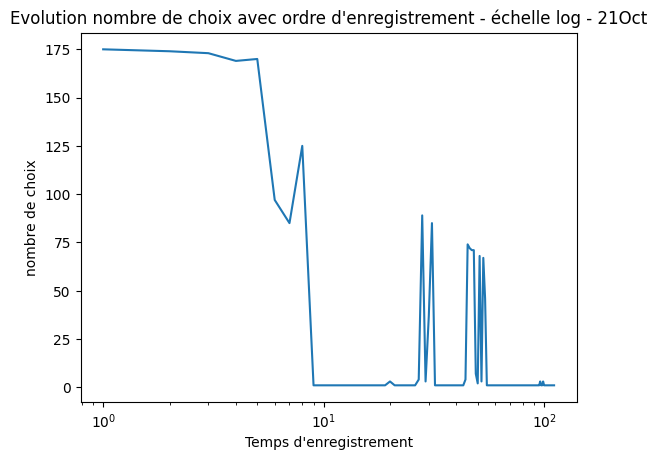

In [69]:
# Assuming ScoreRegisterDict is your dictionary
values = list(ScoreRegisterDict.values())
groups = list(ScoreRegisterDict.keys())

# Create an array for the x-axis values
x_values = np.arange(1, len(values) + 1)

plt.semilogx(x_values, values)
#plt.plot(x_values, values)
plt.xlabel('Temps d\'enregistrement')
plt.ylabel('nombre de choix')
plt.title(f'Evolution nombre de choix avec ordre d\'enregistrement - échelle log - {date}')

directory = f'./Résultats_dynamique/{date}/figures/'  

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the filename
filename = f'Evolution_nbre_choix_logx{date}.png'

# Construct the full path
save_path = os.path.join(directory, filename)



# Save the figure
plt.savefig(save_path)  

plt.show()



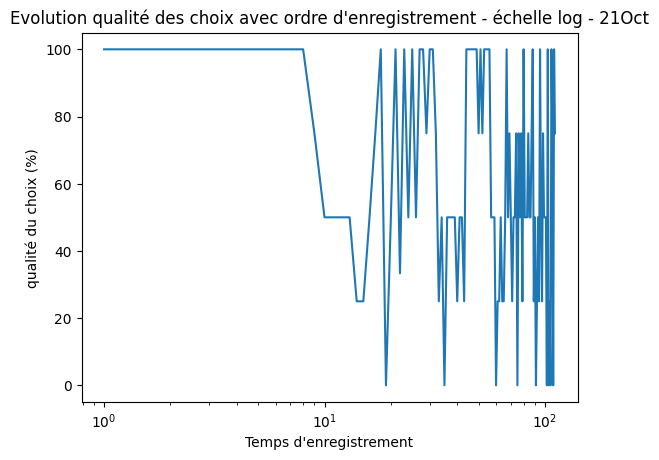

In [68]:
# Assuming ScoreRegisterDict is your dictionary
values = list(ScoreChoiceDict.values())
groups = list(ScoreChoiceDict.keys())

# Create an array for the x-axis values
x_values = np.arange(1, len(values) + 1)

plt.semilogx(x_values, values)

#plt.plot(x_values, values)
plt.xlabel('Temps d\'enregistrement')
plt.ylabel('qualité du choix (%)')
plt.title(f'Evolution qualité des choix avec ordre d\'enregistrement - échelle log - {date}')

directory = f'./Résultats_dynamique/{date}/figures/'  

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the filename
filename = f'Evolution_qualt_choix_logx{date}.png'

# Construct the full path
save_path = os.path.join(directory, filename)

# Save the figure
plt.savefig(save_path)  


plt.show()

- Groups visualisation

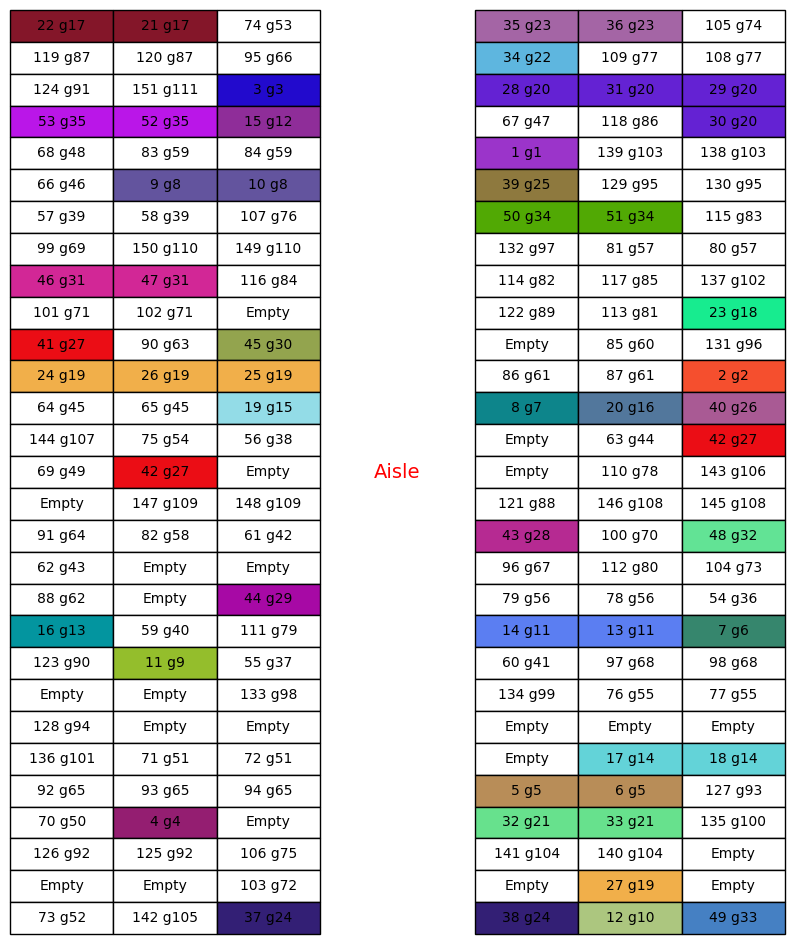

In [64]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(AllGroups))
indices_groups = list(AllGroups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1) }


data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        k = SeatsAssignDict[(i,j)]
        if k != None :
            if j<4:
                data1[i-1][j-1] = f"{k} g{Passengers[k]['group']}"
                if Passengers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passengers[k]['group']]
            else:
                data2[i-1][j-5] = f"{k} g{Passengers[k]['group']}"
                if Passengers[k]['group'] in color_group: colors2[i-1][j-5] = color_group[Passengers[k]['group']]

                    
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

directory = f'./Résultats_dynamique/{date}/figures/'  

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the filename
filename = f'Grouping_Global_dynamique_{date}.png'

# Construct the full path
save_path = os.path.join(directory, filename)

# Adjust figure size
fig.set_size_inches(10, 6)  # Set the figure size to 10x6 inches (adjust as needed)

# Save the figure
fig.savefig(save_path, bbox_inches='tight')  # Use bbox_inches='tight' to ensure all elements fit


plt.show()

In [65]:
print("end.")

end.
